## Gathering Data and imports

In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer/sample_submission.csv
/kaggle/input/customer/Train.csv
/kaggle/input/customer/Test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Insatlling spark and Creating a Spark Session

In [3]:
# Installing pyspark
!pip install pyspark
import pyspark.sql.functions as f
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Multiclass Classification').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285413 sha256=c4cd8a2d66b970cadb57ddb6a9776da0f89138e66f9593816dc085a89e426776
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/24 12:06:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Loading the Train.csv Dataset into a spark DataFrame

In [4]:
df = spark.read.options(delimeter=',', inferSchema=True, header=True).csv('/kaggle/input/customer/Train.csv')
df.show(10)

+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|    ID|Gender|Ever_Married|Age|Graduated|   Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|
+------+------+------------+---+---------+-------------+---------------+--------------+-----------+-----+------------+
|462809|  Male|          No| 22|       No|   Healthcare|            1.0|           Low|        4.0|Cat_4|           D|
|462643|Female|         Yes| 38|      Yes|     Engineer|           null|       Average|        3.0|Cat_4|           A|
|466315|Female|         Yes| 67|      Yes|     Engineer|            1.0|           Low|        1.0|Cat_6|           B|
|461735|  Male|         Yes| 67|      Yes|       Lawyer|            0.0|          High|        2.0|Cat_6|           B|
|462669|Female|         Yes| 40|      Yes|Entertainment|           null|          High|        6.0|Cat_6|           A|
|461319|  Male|         Yes| 56|       No|      

In [5]:
catg_cols = []
num_cols = []
for cols in df.dtypes:
    if cols[1] == 'string' and cols[0] != 'Segmentation':
        catg_cols.append(cols[0])
    elif cols[0] != 'ID':
        num_cols.append(cols[0])

print('Categorical columns are: ',*catg_cols)
print('Numerical columns are:',*num_cols)

Categorical columns are:  Gender Ever_Married Graduated Profession Spending_Score Var_1
Numerical columns are: Age Work_Experience Family_Size Segmentation


### Summary statistics of Numerical / Continuous columns


In [6]:
df.select(*num_cols).summary().show(truncate=False)

23/08/24 12:06:46 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------------+------------------+------------------+------------+
|summary|Age              |Work_Experience   |Family_Size       |Segmentation|
+-------+-----------------+------------------+------------------+------------+
|count  |8068             |7239              |7733              |8068        |
|mean   |43.46690629647992|2.641663213150988 |2.85012285012285  |null        |
|stddev |16.71169631872117|3.4067629854580828|1.5314132820253776|null        |
|min    |18               |0.0               |1.0               |A           |
|25%    |30               |0.0               |2.0               |null        |
|50%    |40               |1.0               |3.0               |null        |
|75%    |53               |4.0               |4.0               |null        |
|max    |89               |14.0              |9.0               |D           |
+-------+-----------------+------------------+------------------+------------+



#### **Here we can observe the following:**
- Customer Age ranges from 18 to 89 with mean of 43.46
- Work Experience range from 0 to 14 Years with mean of 2.64
- Family Size range from 1 to 9 with mean of 2.8

### Finding out missing values in the data

In [7]:
print('Total rows in dataset: ',df.count())

Total rows in dataset:  8068


In [8]:
print('Null Values in each column: ')
df.select([f.count(f.when(f.isnan(c) | f.col(c).isNull(),c)).alias(c) for c in df.columns]).show()

Null Values in each column: 
+---+------+------------+---+---------+----------+---------------+--------------+-----------+-----+------------+
| ID|Gender|Ever_Married|Age|Graduated|Profession|Work_Experience|Spending_Score|Family_Size|Var_1|Segmentation|
+---+------+------------+---+---------+----------+---------------+--------------+-----------+-----+------------+
|  0|     0|         140|  0|       78|       124|            829|             0|        335|   76|           0|
+---+------+------------+---+---------+----------+---------------+--------------+-----------+-----+------------+



### Removing null values for accurate visualization of data

In [9]:
df_nr = df.na.drop()
print('Rows in dataset after removing nulls: ',df_nr.count())

Rows in dataset after removing nulls:  6665


We can deal with missing data by imputation later when modelling

## Visualizations - Univariate and Bivariate Analysis

### Plotting Numerical Columns

In [10]:
pdf = df_nr.toPandas()

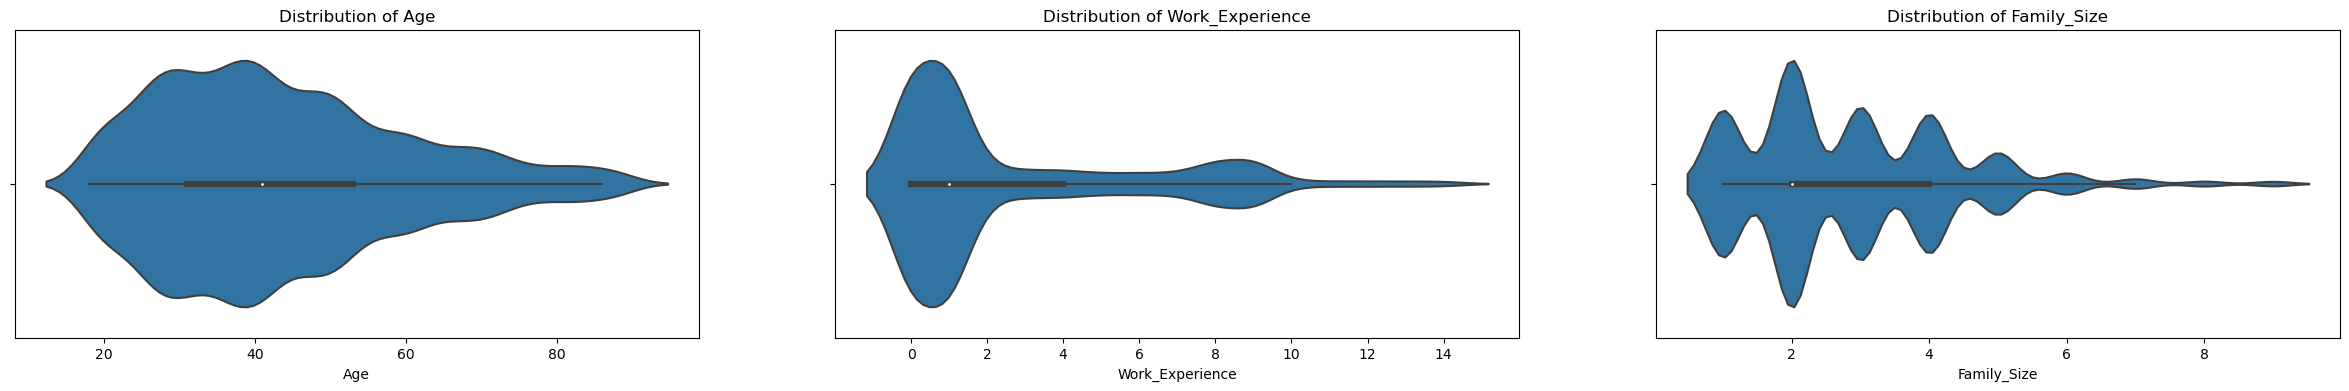

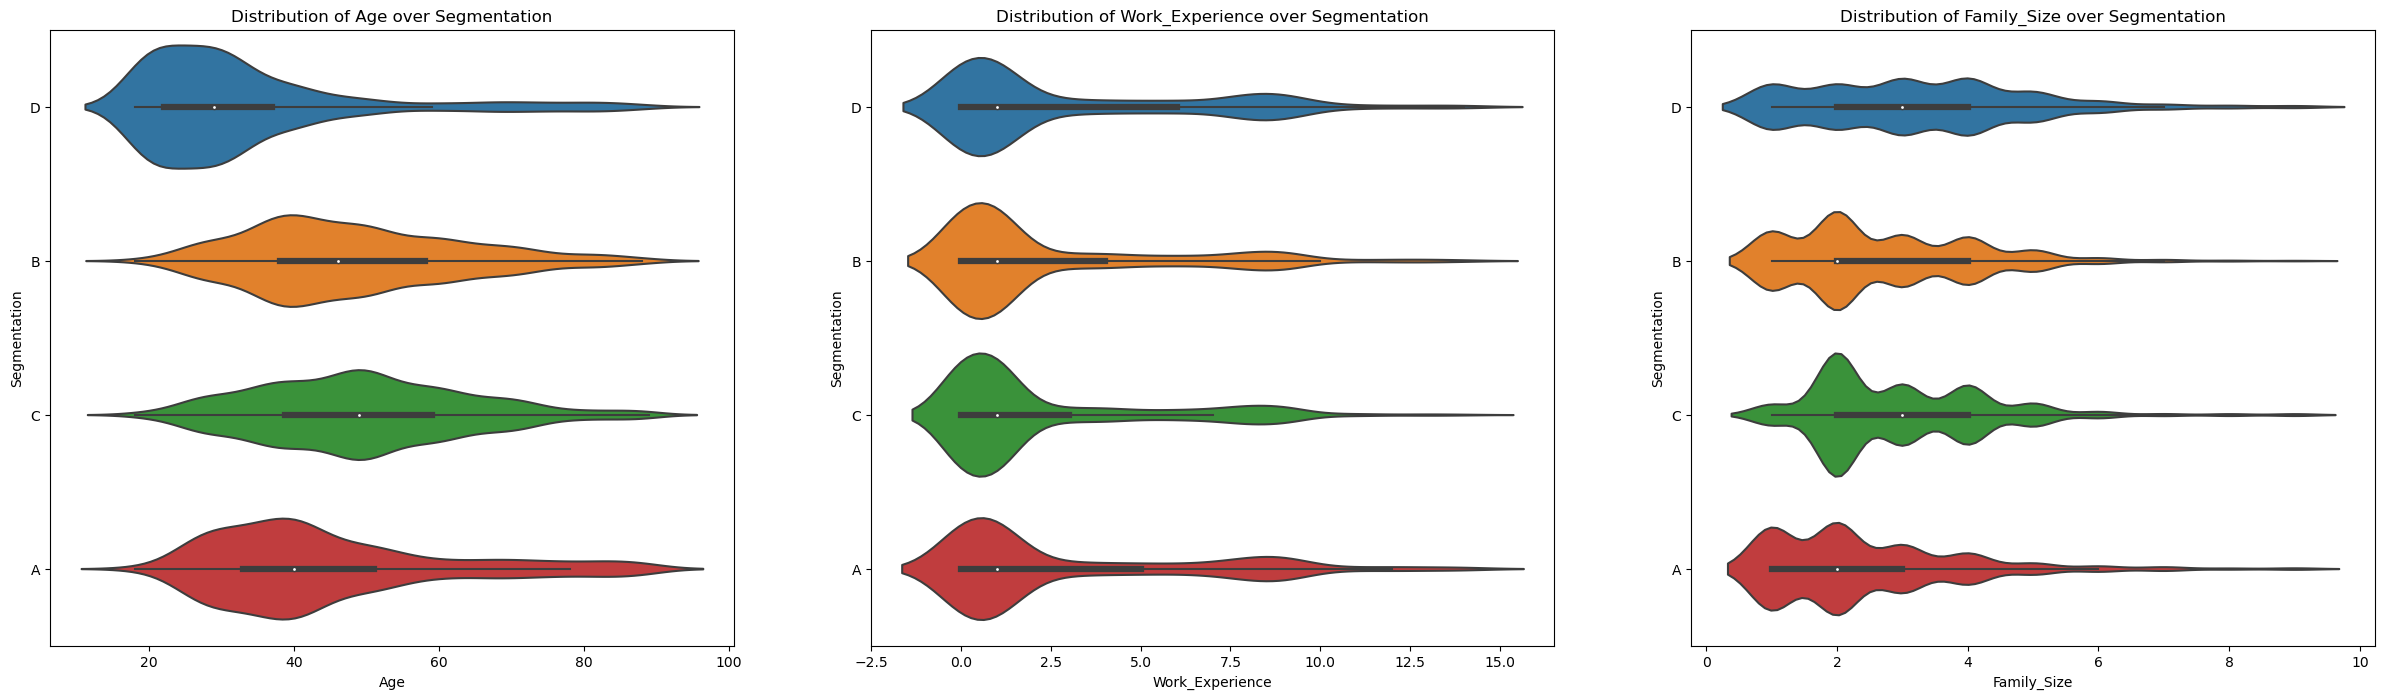

In [11]:
fig, ax = plt.subplots(1,3, figsize=(30,4))
for i, subplots in zip(num_cols, ax.flatten()):
    sns.violinplot( x=pdf[i], ax=subplots).set_title(f'Distribution of {i}')
    
fig, ax = plt.subplots(1,3, figsize=(30,8))
for i, subplots in zip(num_cols, ax.flatten()):
    sns.violinplot(x=i, y='Segmentation', data=pdf, ax=subplots).set_title(f'Distribution of {i} over Segmentation')

#### **Following observations can be derived from the above plots:**
- Age looks closer to a normal distribution, with median close to 40
- If we look at distribution of age over segmentation: 
    - 'D' Has younger customers with median age between 20-40
    - 'A' customers with median age 40
    - 'B' And 'C' are identical with respect to age, their median is close to 50  <br>
<br>
- Maximum population has Work experience less than 2 years
- Experience is identical over all segments as the median does not shift
<br>
<br>
- Maximum population has fimily size less than 5, with a spike at 2
- If we look closely at distribution of family sizer over segments:
    - 'D' follows a uniform distribution till 4, with median size close to 3
    - 'B' and 'A' has median close to 2, but B has q3 till 4, and A has q3 till 3
    - 'C' has median close to 3, with a spike at 2

### Plotting Categorical Columns

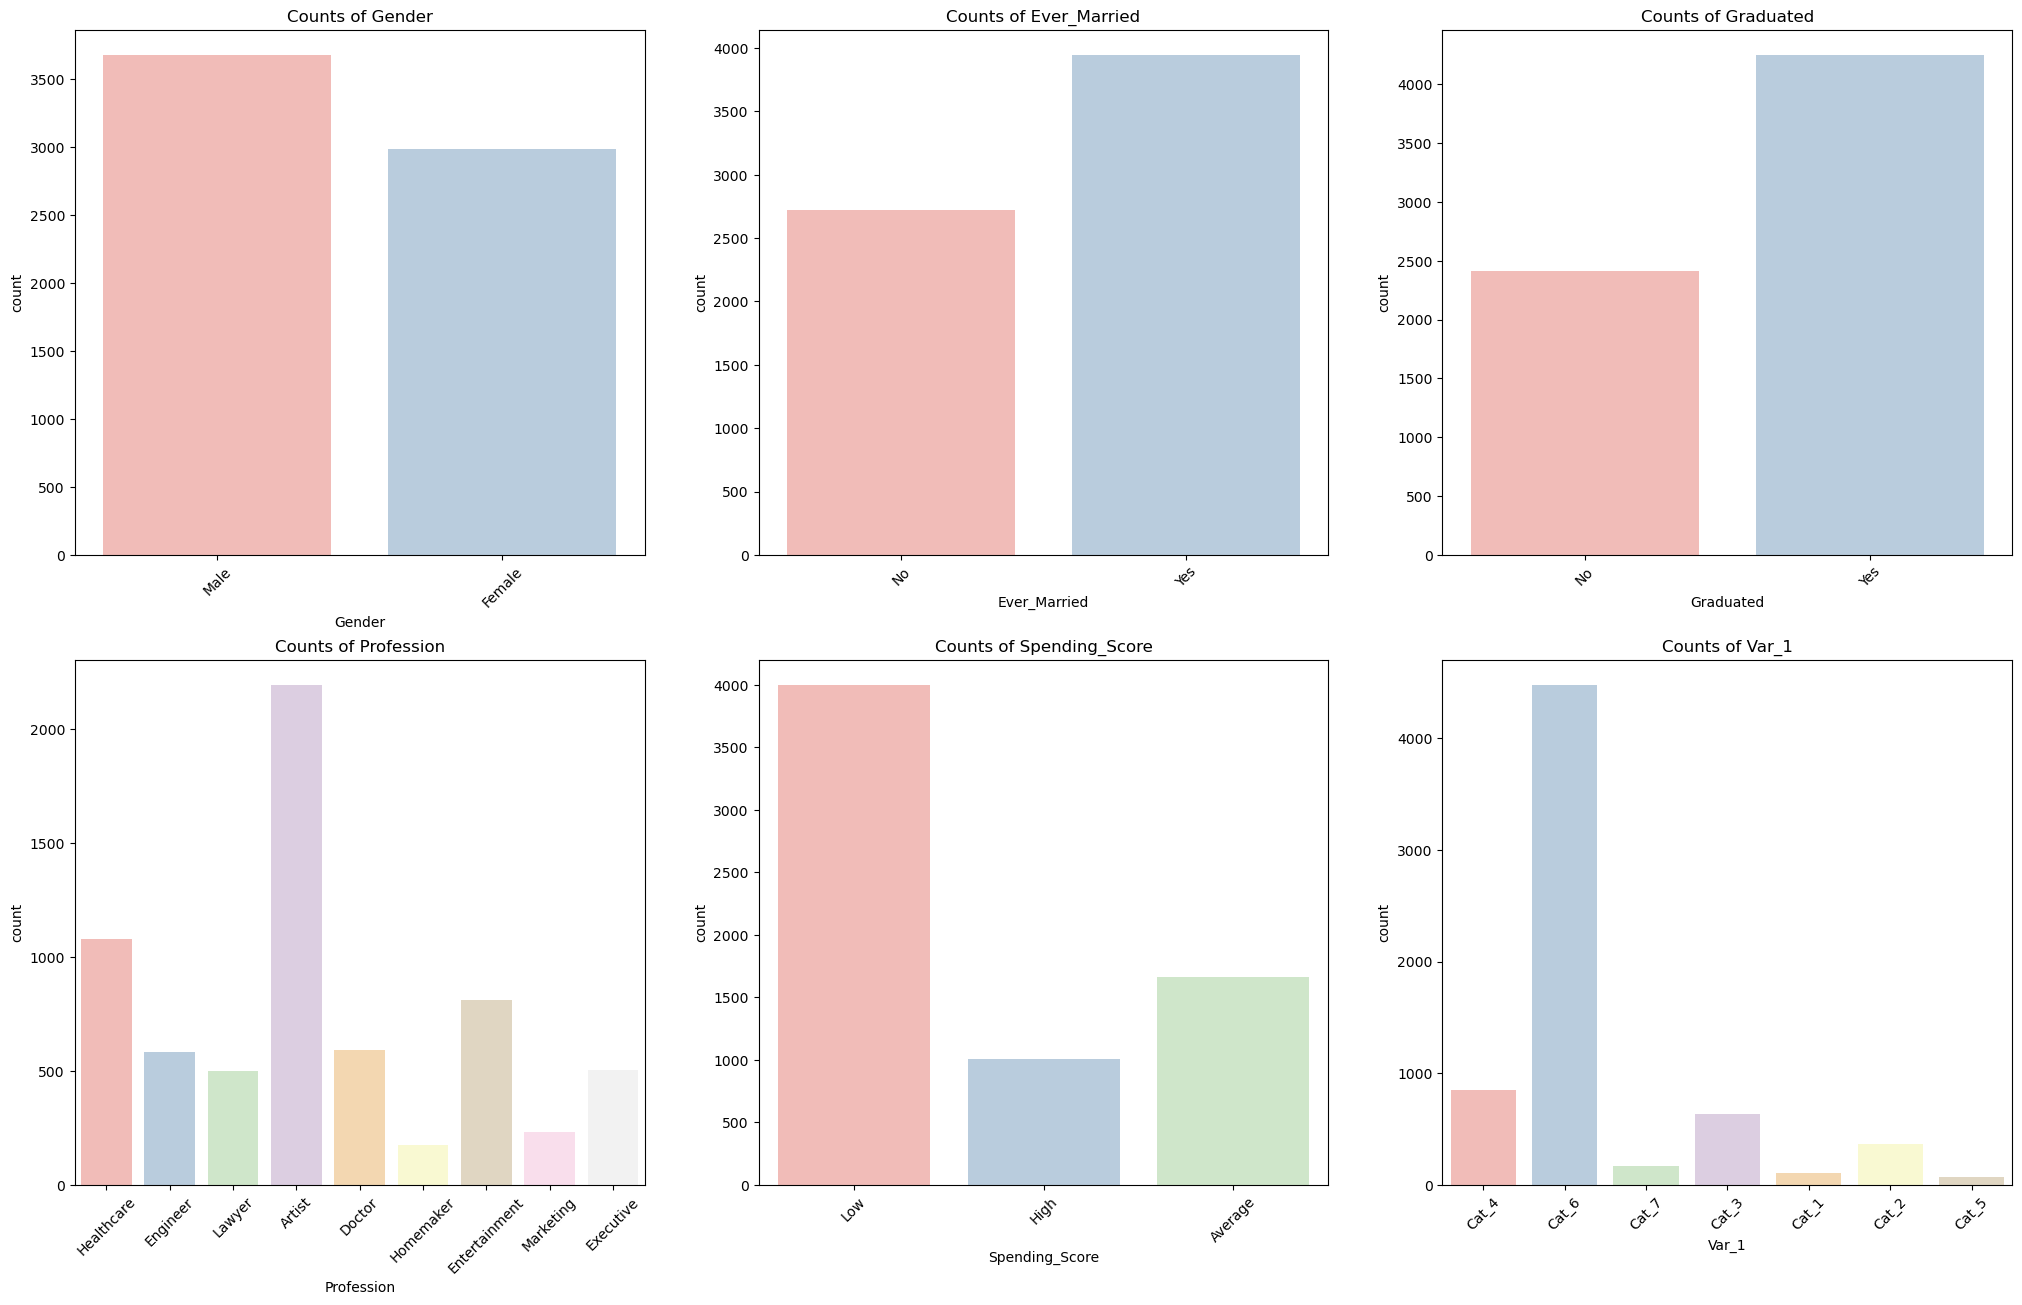

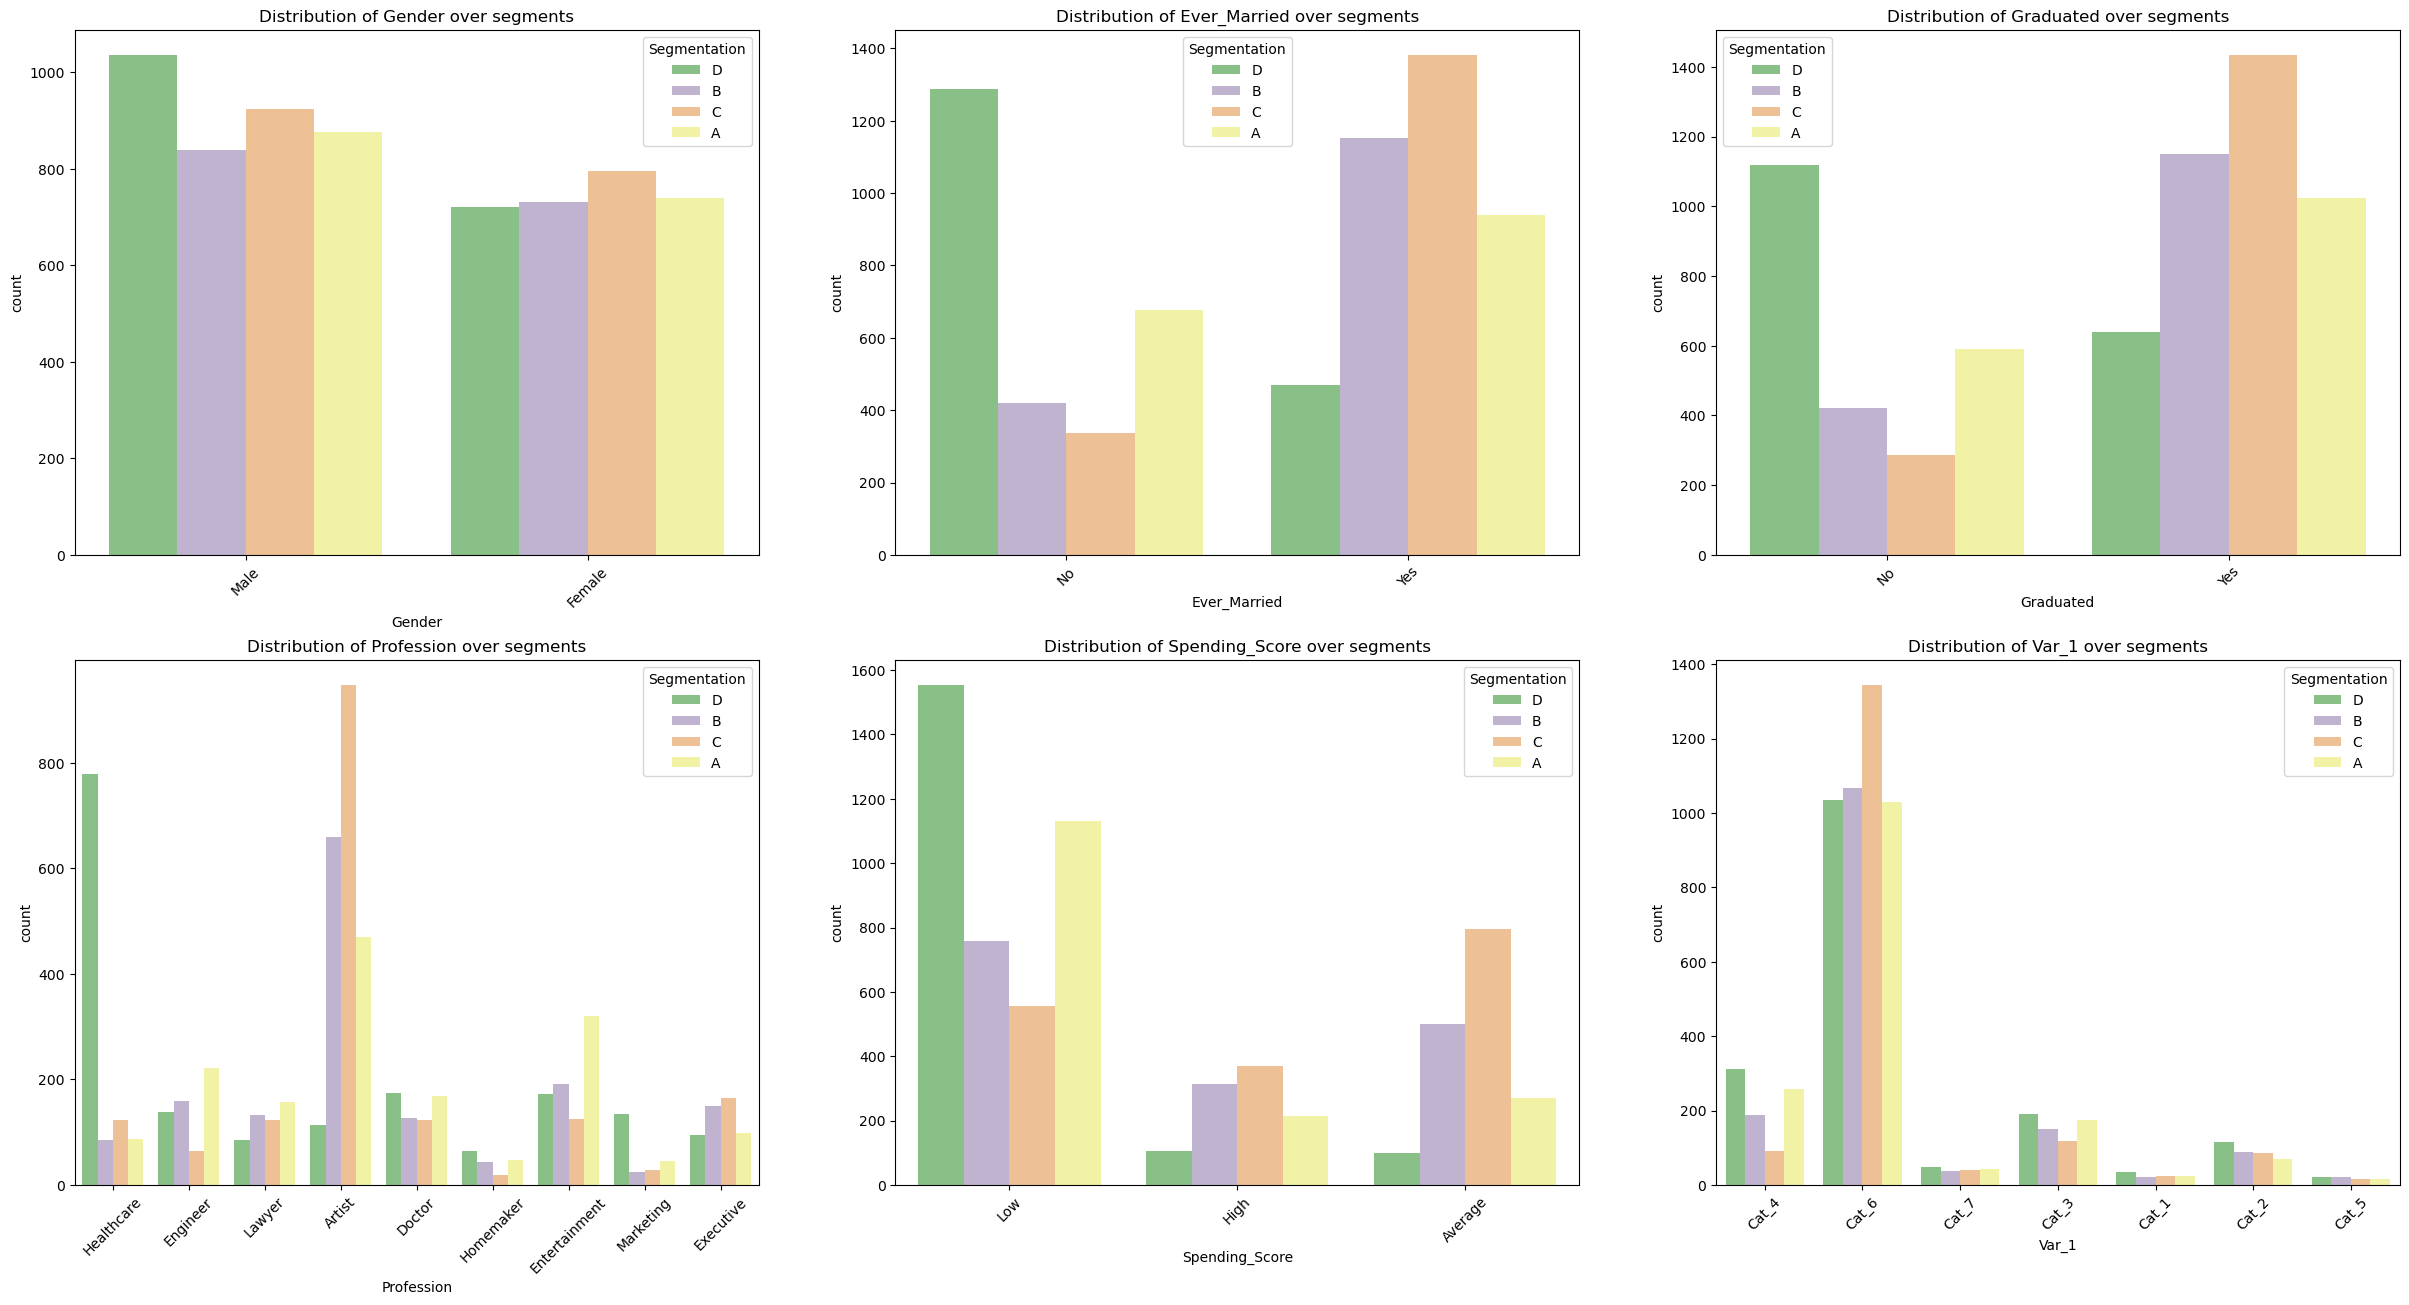

In [12]:
fig, ax = plt.subplots(2,3, figsize=(25,15))
for i, subplots in zip(catg_cols, ax.flatten()):
    sns.countplot( x=pdf[i], ax=subplots, palette='Pastel1').set_title(f'Counts of {i}')
    subplots.tick_params(axis='x', rotation=45)
    
fig, ax = plt.subplots(2,3, figsize=(30,15))
for i, subplots in zip(catg_cols, ax.flatten()):
    sns.countplot( x=i,data=pdf,hue='Segmentation', ax=subplots, palette='Accent').set_title(f'Distribution of {i} over segments')
    subplots.tick_params(axis='x', rotation=45)

#### Following Observations can be derived from the plots above
- **Gender** : Male population is slightly higher than female
    - All segments are equally distributed between male and female
<br>
<br>
- **Ever_Married** : Counts of married people are higher
    - Segment D seems to have more number of unmarried customers
    - Segment B and C have more number of married customers
<br>
<br>
- **Graduated** : Counts of graduated people are higher
    - Segment D seems to have higher number of non graduated customers
    - Segment B and C have more number of graduated customers
<br>
<br>
- **Profession** : Highest number of customers are artists, and Hommemakers being the least
    - Segment C seems to have highest number of Artists
    - Segment D have highest number of Helthcare and Marketing professionals compared to others
    - Segment A has highest number of customers in Entertainment
    <br>
<br>
- **Spending Score** : Most customers are low spenders
    - Segment D and A spend the lowest among other segments
    - Segment B and C have equal number of customer spread over high, avg and low spending score
<br>
<br>
- **Var_1** (Anonimized categories for customer): Most customers fall in category 6, and least being category 5
    - Segment C have highest customers in categoty 6
    - Other categories are almost equally distributed

### Plotting Label (Segmentation)

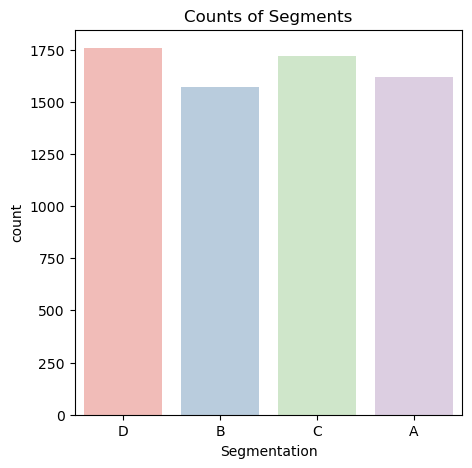

In [13]:
plt.figure(figsize=(5,5))
sns.countplot(x=pdf['Segmentation'],  palette='Pastel1').set_title(f'Counts of Segments')
plt.show()

**The Segmentation Column is equally distributed, Hence we wont need to perform subsampling later**